# Carga de datos

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
zip_path = "/content/drive/MyDrive/Colab Notebooks/MNA/Proyecto Integrador/CORD-1k-001.zip"


In [77]:
#carpeta para descomprimir
import os

EXTRACT_PATH = "/content/drive/MyDrive/Colab Notebooks/MNA/Proyecto Integrador/cord_dataset"
os.makedirs(EXTRACT_PATH, exist_ok=True)

In [78]:
#extraer .zip file

import zipfile

print("Extrayendo archivos...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(EXTRACT_PATH)

print("Extraccion completa")

Extrayendo archivos...
Extraccion completa


In [79]:
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/MNA/Proyecto Integrador/cord_dataset/CORD/"


In [80]:
!ls "{BASE_PATH}"
!find "/content/drive/MyDrive" -type d -name "CORD"
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/MNA/Proyecto Integrador/cord_dataset/CORD/"
!ls "/content/drive/MyDrive/Colab Notebooks/MNA/Proyecto Integrador/cord_dataset/CORD"

dev  test  train
/content/drive/MyDrive/Colab Notebooks/MNA/Proyecto Integrador/cord_dataset/CORD
dev  test  train


In [81]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

plt.style.use("ggplot")

In [82]:
splits = ["train", "dev", "test"]

In [83]:
import json

def parse_cord1k_json(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    image_id = data["meta"]["image_id"]

    items = []
    quantities = []
    prices = []

    total = None
    cash = None
    change = None

    # Recorremos todas las líneas válidas
    for line in data["valid_line"]:
        category = line["category"]
        words = [w["text"] for w in line["words"]]

        text_joined = " ".join(words)

        # → Items (nombre)
        if category == "menu.nm":
            items.append(text_joined)

        # → Cantidades
        elif category == "menu.cnt":
            quantities.append(text_joined)

        # → Precios por item
        elif category == "menu.price":
            prices.append(text_joined)

        # → Total del ticket
        elif category == "total.total_price":
            total = words[-1]  # último valor numérico

        # → Pago (cash)
        elif category == "total.cashprice":
            cash = words[-1]

        # → Cambio
        elif category == "total.changeprice":
            change = words[-1]

    return {
        "image_id": image_id,
        "items": items,
        "quantities": quantities,
        "prices": prices,
        "total": total,
        "cash": cash,
        "change": change
    }

In [84]:
def clean_number(x):
    if x is None:
        return None
    try:
        return float(x.replace(",", "").replace("$", "").strip())
    except:
        return None


In [85]:
def load_cord_split(split_path):
    rows = []
    json_dir = os.path.join(split_path, "json")

    for file in os.listdir(json_dir):
        if not file.endswith(".json"):
            continue

        json_path = os.path.join(json_dir, file)
        ticket = parse_cord1k_json(json_path)

        items = ticket["items"]
        quantities = ticket["quantities"]
        prices = ticket["prices"]

        quantities = [clean_number(q) for q in quantities]
        prices = [clean_number(p) for p in prices]

        for item, qty, prc in zip(items, quantities, prices):

            rows.append({
                "image_id": ticket["image_id"],
                "item": item,
                "quantity": qty,
                "price": prc,
                "total": clean_number(ticket["total"]),
                "cash": clean_number(ticket["cash"]),
                "change": clean_number(ticket["change"])
            })

    return pd.DataFrame(rows)



In [86]:
train_df = load_cord_split(BASE_PATH + "train/")
dev_df   = load_cord_split(BASE_PATH + "dev/")
test_df  = load_cord_split(BASE_PATH + "test/")

df = pd.concat([train_df, dev_df, test_df], ignore_index=True)
df.head()


,image_id,item,quantity,price,total,cash,change
0,35,Cuka Apel Moringa,1.0,289000.0,NaN,300000.0,11000.0
1,376,SWEEAT ICE TEA,1.0,16800.0,181271.0,NaN,NaN
2,376,OREO MILK BLEND,1.0,28800.0,181271.0,NaN,NaN
3,376,FRIED RC SFOOD,1.0,39800.0,181271.0,NaN,NaN
4,376,SHISHA,1.0,47000.0,181271.0,NaN,NaN


# Feature engineering

Se realiza esta parte para saber si el dataset es consistente, si tiene valores faltantes y si las variables tienen la distribucion adecuada para transformaciones posteriores.

In [87]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2262 entries, 0 to 2261
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image_id  2262 non-null   int64  
 1   item      2262 non-null   object 
 2   quantity  1844 non-null   float64
 3   price     2220 non-null   float64
 4   total     2164 non-null   float64
 5   cash      1044 non-null   float64
 6   change    1084 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 123.8+ KB


In [88]:
df.describe()

,image_id,quantity,price,total,cash,change
count,2262.00000,1844.000000,2.220000e+03,2.164000e+03,1044.000000,1084.000000
mean,337.67595,2.945770,3.793378e+04,2.662399e+05,78149.996503,12081.712186
std,248.55970,33.944151,8.420282e+04,4.976217e+05,136984.340768,20718.444821
min,0.00000,1.000000,0.000000e+00,5.000000e+00,0.000000,-30000.000000
25%,85.00000,1.000000,5.600000e+01,1.178100e+03,100.000000,0.000000
50%,313.50000,1.000000,1.800000e+04,6.350000e+04,50000.000000,44.500000
75%,552.00000,1.000000,4.109075e+04,2.820000e+05,100000.000000,20000.000000
max,799.00000,1000.000000,1.944000e+06,3.920000e+06,770000.000000,97000.000000


In [89]:
df.isnull().sum().sort_values(ascending=False)

,0
cash,1218
change,1178
quantity,418
total,98
price,42
item,0
image_id,0


# Generacion de nuevas caracteristicas

**Precio unitario**

Es útil para detectar inconsistencias, promociones o descuentos.

In [90]:
df["unit_price"] = df["price"] / df["quantity"]
df[["price", "quantity", "unit_price"]].head()

,price,quantity,unit_price
0,289000.0,1.0,289000.0
1,16800.0,1.0,16800.0
2,28800.0,1.0,28800.0
3,39800.0,1.0,39800.0
4,47000.0,1.0,47000.0


**Longitud del nombre del producto**

Podria ser útil se despues se entrenan modelos de clasificación de productos o limpieza OCR

In [91]:
df["name_length"] = df["item"].str.len()
df[["item", "name_length"]].head()

,item,name_length
0,Cuka Apel Moringa,17
1,SWEEAT ICE TEA,14
2,OREO MILK BLEND,15
3,FRIED RC SFOOD,14
4,SHISHA,6


**Diferencia entre cash y total (si existe)**

Esto permite identificar:

*   Errores de OCR
*   inconsistencias en el ticket
*   Algun comportamiento fraudulento

Esta es una caracteristica muy útil para detección de anomalías.






In [92]:
df["cash_diff"] = df["cash"] - df["total"]
df[["cash", "total", "cash_diff"]].head()


,cash,total,cash_diff
0,300000.0,NaN,NaN
1,NaN,181271.0,NaN
2,NaN,181271.0,NaN
3,NaN,181271.0,NaN
4,NaN,181271.0,NaN


**Conteo de productos por ticket**

Los modelos suelen beneficiarse de un tamaño del contexto.
La cantidad de productos puede estar asociado con:


*   El monto total
*   El tipo de comercio
*   La estructura del ticket







In [93]:
df["items_per_ticket"] = df.groupby("image_id")["item"].transform("count")
df[["image_id", "items_per_ticket"]].drop_duplicates().head()


,image_id,items_per_ticket
0,35,9
1,376,5
6,638,1
7,605,2
9,273,1


**Indicadores binarios de información disponible**

Realizar una transformación a valores faltantes en indicadores binarios permite informar al modela sobre la ausencia de algun dato.

In [94]:
df["has_cash_info"] = df["cash"].notnull().astype(int)
df["has_change_info"] = df["change"].notnull().astype(int)

df[["cash", "has_cash_info", "change", "has_change_info"]].head()

,cash,has_cash_info,change,has_change_info
0,300000.0,1,11000.0,1
1,NaN,0,NaN,0
2,NaN,0,NaN,0
3,NaN,0,NaN,0
4,NaN,0,NaN,0


**Completeness score**

Ya que los datos se consumiran vía API, el saber que tan completo esta un ticket ayuda a:

*  Priorizar revisiones
*  Decidir que mandar al API
*  Medir la calidad del OCR

In [95]:
df["completeness_score"] = (df[["quantity", "price", "total"]].notnull().sum(axis=1) / 3)
df[["quantity", "price", "total", "completeness_score"]].head()

,quantity,price,total,completeness_score
0,1.0,289000.0,NaN,0.666667
1,1.0,16800.0,181271.0,1.000000
2,1.0,28800.0,181271.0,1.000000
3,1.0,39800.0,181271.0,1.000000
4,1.0,47000.0,181271.0,1.000000


# Selección de características

**Matriz de correlación**

Permite detectar:
*   redundancia entre variables
*   variables altamente correlacionados con el target

In [96]:
# Cantidad de items únicos por ticket
df["unique_items_per_ticket"] = df.groupby("image_id")["item"].transform("nunique")


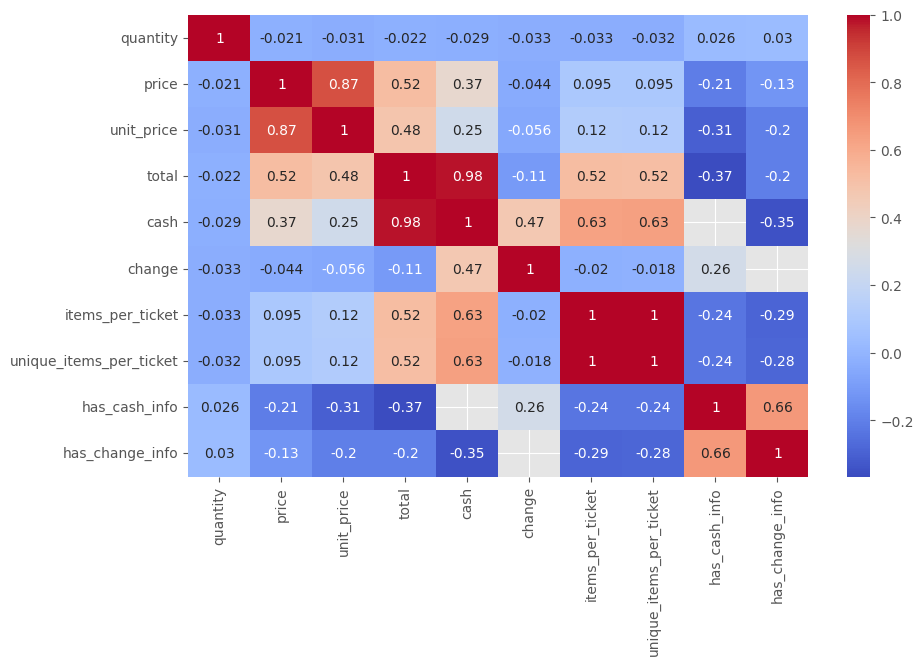

In [97]:
num_df = df[["quantity", "price", "unit_price", "total", "cash", "change",
            "items_per_ticket", "unique_items_per_ticket",
            "has_cash_info", "has_change_info"]]

plt.figure(figsize=(10,6))
sns.heatmap(num_df.corr(), annot=True, cmap="coolwarm")
plt.show()


**Boxplots por variable**

Este metodo es para visualizar outliers rapidamente

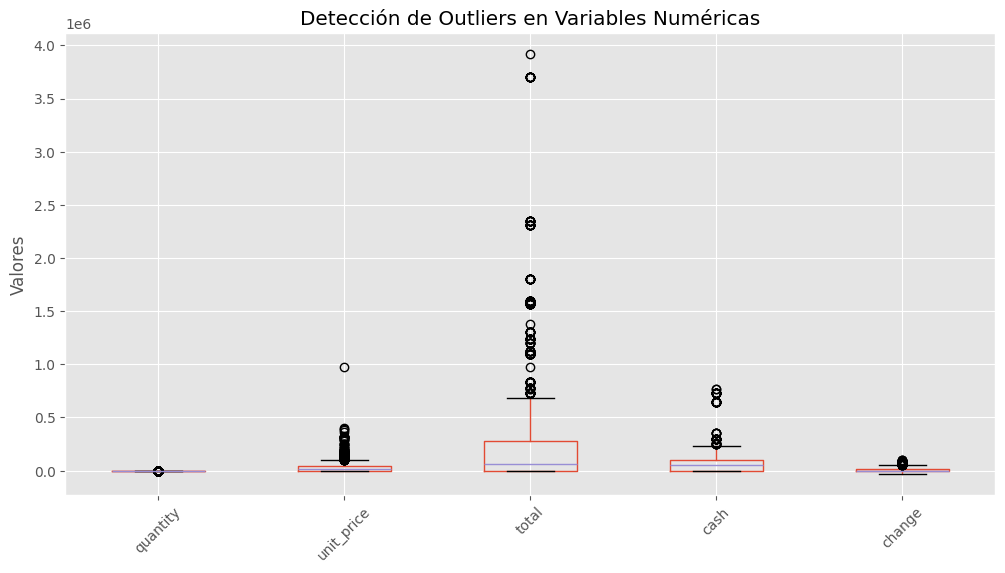

In [98]:
cols = ["quantity", "unit_price", "total", "cash", "change"]

plt.figure(figsize=(12, 6))
df[cols].boxplot()
plt.title("Detección de Outliers en Variables Numéricas")
plt.ylabel("Valores")
plt.xticks(rotation=45)
plt.show()

**Validación de proporciones**

Es para verificar que los calculos internos del ticket sean lógicos.

In [99]:
df["calc_total"] = df["quantity"] * df["unit_price"]

df["total_error"] = df["total"] - df["calc_total"]

df[["quantity", "unit_price", "total", "calc_total", "total_error"]].head()


,quantity,unit_price,total,calc_total,total_error
0,1.0,289000.0,NaN,289000.0,NaN
1,1.0,16800.0,181271.0,16800.0,164471.0
2,1.0,28800.0,181271.0,28800.0,152471.0
3,1.0,39800.0,181271.0,39800.0,141471.0
4,1.0,47000.0,181271.0,47000.0,134271.0


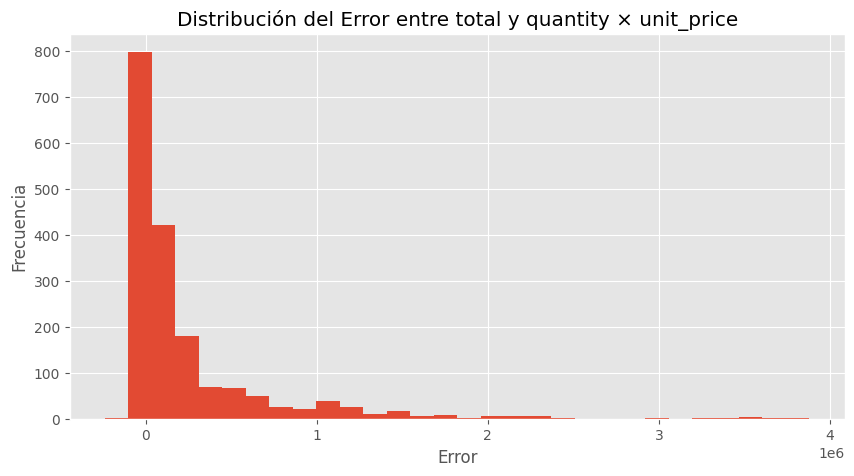

In [100]:
plt.figure(figsize=(10,5))
plt.hist(df["total_error"], bins=30)
plt.title("Distribución del Error entre total y quantity × unit_price")
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.show()


# Conclusiones

Las tecnicas utilizadas en esta parte del proyecto fueron elegidas porque permiten transformar los datos OCR del dataset CORD, el cual aún no es el dataset de Bimbonet, en información numérica y estructurada, facilitando su análisis. Estas técnicas ayudan a medir la calidad del OCR, detectar alguna inconsistencia y generar variables útiles para etapas posteriores.

Varias de las tecnicas propuestas que se mencionan en el trabajo como PCA, Once hot encoding, Umbral de varianza, etc, fueron descartadas ya que no aportaban un valor significativo al tipo de datos ni a los objetivos de los proyectos.

Se quiere volver a aclarar que estos datos no son los datos requeridos para el proyecto, son una base de datos libre de Github, una vez que se tengan los datos necesarios para le proyecto esta parte de Feature Engineering se hara para obtener la informacion relevante y necesaria para lograr el objetivo del proyecto.